In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import glob


In [5]:
csv_Path = "/home/digital101/LinuxCodingFolder/HandGestureProject/HandGestureDataSet/GatherData/Sunny"

csv_files = glob.glob("/home/digital101/LinuxCodingFolder/HandGestureProject/HandGestureDataSet/GatherData/Sunny/*.csv")  # Replace with your folder path

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    df["gesture_label"] = file.split("/")[-1].split(".")[0]  # Extract label from filename
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
data.head()


,threshVal,depthLevel,numHullPoints,numDefects,bbox.width,bbox.height,aspect_ratio,area,perimeter,gesture_label
0,144,10,11,8,182,273,0.666667,13391.5,850.423,pinch_4
1,144,10,11,5,182,273,0.666667,13376.5,850.423,pinch_4
2,144,10,12,6,182,273,0.666667,13361.0,847.352,pinch_4
3,144,10,11,5,183,273,0.670330,13338.5,850.080,pinch_4
4,144,10,12,6,183,273,0.670330,13325.0,848.666,pinch_4


In [6]:
X = data.drop(columns=["gesture_label"])  # Features
y = data["gesture_label"]                 # Labels

# Encode gesture labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


In [8]:
model = SVC(kernel='rbf', C=1, gamma='scale')
model.fit(X_train, y_train)


,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


#### F1 scores 
- The `harmonic mean` of precision and recall
  - Harmonic mean : type of average that's useful for rates and ratio
  - Example : speed
  - How to calculate : `HM = n / (1/x1 + 1/x2 + ... + 1/xn)`
- Metric used to provide balanced measures of a classification model's performance by considering both `precision` and `recall`
  - Useful metric for `imbalanced datasets` where both precision and recall may be knewed 

#### Support
- The number of actual occurances of the class in the dataset 
- TL;DR : The number of instances in each class
#### Precision 
- Measure of accuracy of positive predictions 
- It's the proportion of `correctly predicted positive cases` out of all the instances predicted as positive 
- Answers the question : "Of all the instances the model classified as positive, how many were actually positive?"
  - It's all about the reliability of the model's positive predictions 
- High precision --> few false positive errors 

#### Recall 
- Measures how well the model IDs all actual positive cases `in the dataset`
- It's proportional to the `correctly predicted positive cases` out of all actual positive cases 
- Answers the question : "Of all the actual positive instances, how many did the model correctly identify?"
  - It's about the model's ability to find all relevant instances
- High recall score --> Model made few false negative errors 
- TL;DR : How good is the model catching all the positive cases

              precision    recall  f1-score   support

 closeFist_1       0.82      0.72      0.77       177
 closeFist_2       0.50      0.75      0.60       177
 closeFist_3       0.90      0.89      0.90       177
 closeFist_4       0.56      0.68      0.61       177
 closeFist_5       0.83      0.73      0.77       177
     number1       0.57      0.59      0.58       177
   number1_2       0.61      0.49      0.54       177
   number1_3       0.58      0.25      0.35       177
   number1_4       0.35      0.47      0.40       177
     pinch_1       0.41      0.64      0.50       176
     pinch_2       0.45      0.39      0.42       177
     pinch_3       0.57      0.40      0.47       176
     pinch_4       0.46      0.56      0.51       177
     pinch_5       0.73      0.44      0.54       177

    accuracy                           0.57      2476
   macro avg       0.60      0.57      0.57      2476
weighted avg       0.60      0.57      0.57      2476



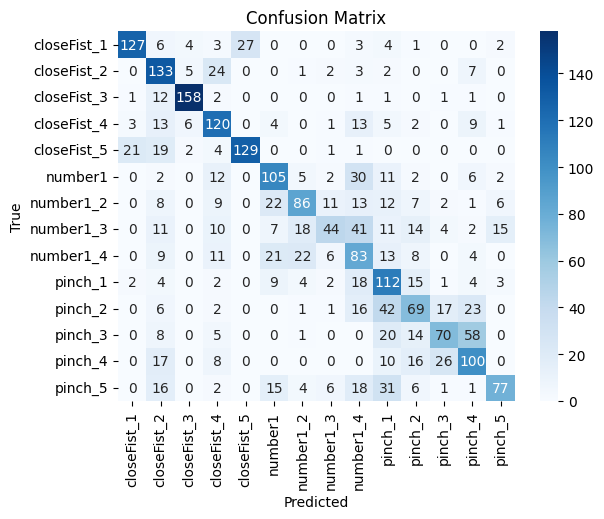

In [9]:
y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [11]:
# Export Your SVM Model to ONNX

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Assume 'model' is your trained sklearn SVM
initial_type = [('input', FloatTensorType([None, 9]))]

# Force IR version 9
onnx_model = convert_sklearn(model, initial_types=initial_type, target_opset=12, options={'zipmap': False})
onnx_model.ir_version = 9  # ← This is the key line

with open("gesture_svm.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())
